# Zoidberg 2.0

## Introduction

We were given a dataset of x-rays, which took around 20 minutes to install from their server. To speed things up and for convenience we sanitized the dataset and uploaded it to hugging face hub. We will see how fast and concise this solution turned out to be.

We outsourced the following data processing tasks to these files :

- [Finding the right image mask](./src/image_mask.ipynb)
- [Data preprocessing and saving in `.npz` file](./src/image_mask.ipynb)

Our goal with the dataset is to find the right machine learning model to help doctors in detecting pneumonia. We will proceed by pulling the `train` split of the dataset (as you can see with the `split="train"` parameter).


We will begin by loading the **preprocessed** dataset from the file.


In [54]:
import numpy as np

processed_data = np.load("./datasets/processed_data.npz", allow_pickle=True)

In [55]:
x_train = processed_data["x_train"]
y_train = processed_data["y_train"]
x_test = processed_data["x_test"]
y_test = processed_data["y_test"]
x_eval = processed_data["x_eval"]
y_eval = processed_data["y_eval"]

In [56]:
import os

if os.path.exists("./datasets/x_train_pca.npy"):
    x_train_pca = np.load("./datasets/x_train_pca.npy")
    x_test_pca = np.load("./datasets/x_test_pca.npy")
    x_eval_pca = np.load("./datasets/x_eval_pca.npy")

Then we will calculate the offset from the geometric center of each image of the training set using the following functions.


In [57]:
from scipy.ndimage import center_of_mass
import math


def get_center_of_mass(image):
    """
    Calculate the center of mass of a binary image.

    This function takes a binary image as input, where foreground pixels are represented as True (or 1)
    and background pixels are represented as False (or 0). It then computes the center of mass (COM)
    of the binary image, which represents the average position of all the foreground pixels.

    Parameters:
    - image: numpy.ndarray
        The input binary image represented as a NumPy array.

    Returns:
    - center: tuple
        A tuple containing the coordinates (row, column) of the center of mass of the binary image.
        The row and column indices start from 0.

    Note:
    - The input image should be a binary image where foreground pixels are represented by True (or 1) and
      background pixels are represented by False (or 0).
    - The center of mass is computed using the center_of_mass function from the scipy.ndimage module.
      Make sure to import this function before using get_center_of_mass.
    """
    binary_image = np.array(image) > 128
    com = center_of_mass(binary_image)
    return (0, 0) if np.isnan(com).any() else com


def calculate_offset(image):
    """
    Calculate the offset between the center of mass (COM) and the geometric center of a binary image.

    Parameters:
    - image: numpy.ndarray
        The input binary image represented as a NumPy array.

    Returns:
    - offset: numpy.ndarray
        A NumPy array representing the offset between the center of mass and the geometric center.
        The offset is computed as the center of mass (COM) minus the geometric center.
        The offset has the same dimensionality as the input image.

    Note:
    - The geometric center is computed as the center of the image grid, which is assumed to be at the
      half width and half height of the image.
    - The offset indicates the displacement of the center of mass relative to the geometric center.
    """

    com = get_center_of_mass(image)

    image = np.array(image)

    geometric_center = np.array(image.shape) / 2

    # print(geometric_center)

    offset = geometric_center - com

    # Check for NaN in the tuple
    if any(math.isnan(x) for x in offset):
        raise Exception("nan found")

    return offset

In [58]:
offsets = [calculate_offset(img) for img in x_train]

mean x offset :  -0.8275138212987382
mean y offset :  -20.179250145815896


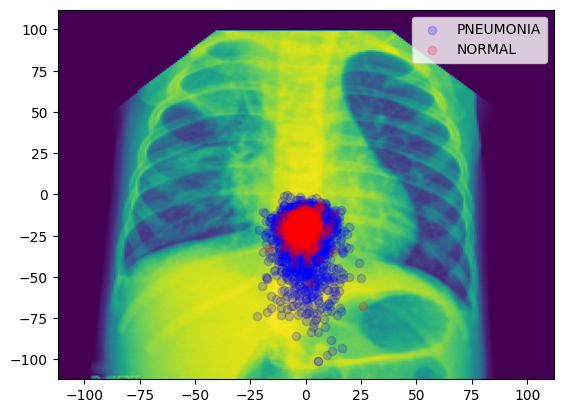

In [59]:
from matplotlib import pyplot as plt
import random

x_offsets = np.array([offset[1] for offset in offsets])
y_offsets = np.array([offset[0] for offset in offsets])
x_offsets_normal = x_offsets[y_train == 0]
x_offsets_pneumonia = x_offsets[y_train == 1]
y_offsets_normal = y_offsets[y_train == 0]
y_offsets_pneumonia = y_offsets[y_train == 1]

print("mean x offset : ", np.mean(x_offsets))
print("mean y offset : ", np.mean(y_offsets))

# Dividing by image sizes
extent = [-224 / 2, 224 / 2, -224 / 2, 224 / 2]

# Display the image with the calculated extents
plt.imshow(x_train[int(random.random() * len(x_train))], extent=extent, aspect="auto")
plt.scatter(
    x_offsets_pneumonia, y_offsets_pneumonia, color="blue", alpha=0.2, label="PNEUMONIA"
)
plt.scatter(x_offsets_normal, y_offsets_normal, color="red", alpha=0.2, label="NORMAL")

plt.legend()
plt.show()

We can notice that on the y axis, the points are pulled towards the bottom which can be explained because of the the visible **pelvis bone** in some of the images resulting in a pull of the **center of mass** towards it.

What's also interesting and can be deduced, is how the images of `NORMAL` patients have a more grouped and centered **center of mass** compared to the patients with `PNEUMONIA`.


## Dimension Reduction

We will first do a **Principal Component Analysis** (`PCA`) to reduce the dimensionality of the images, and then we will plot the first two `PCA`s and then the third in a 3-D plot.

> **NOTE:** This might take a few minutes depending on your hardware, but it's totally worth it


> **NOTE 2:** To cut on wait times set `n_components` to `0.8` it will keep $80\%$ of the dataset's information.


> **NOTE 3:** We will demonstrate why `0.8` [here](#comparing-classification-results-with-different-n_components)


> **NOTE 4:** If you already have the resulting numpy array stored in a file you can skip this step and the following analysis and move to [model discovery](#model-discovery)


In [60]:
# The following function will flatten the images to vectors
# It will also normalized their values (between 0 and 1)
def normalize_images(images):
    return np.array([np.asarray(img).ravel() / 255.0 for img in images])

In [61]:
from sklearn.decomposition import PCA

pca = PCA(n_components=31)

x_train_pca = pca.fit_transform(normalize_images(x_train))

In [62]:
np.save("./datasets/x_train_pca", x_train_pca)

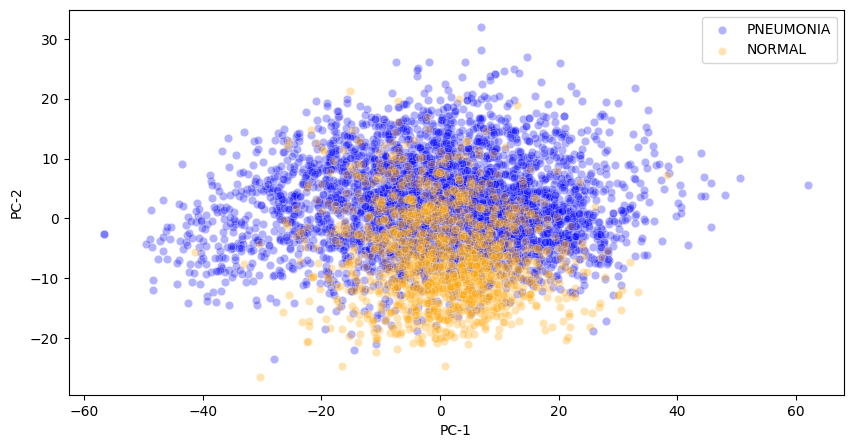

In [63]:
%matplotlib inline
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.scatterplot(x=x_train_pca[y_train == 1, 0], y=x_train_pca[y_train == 1, 1], color="blue", label="PNEUMONIA", alpha=0.3)
sns.scatterplot(x=x_train_pca[y_train == 0, 0], y=x_train_pca[y_train == 0, 1], color="orange", label="NORMAL", alpha=0.3)
plt.xlabel("PC-1"), plt.ylabel("PC-2")
plt.show()

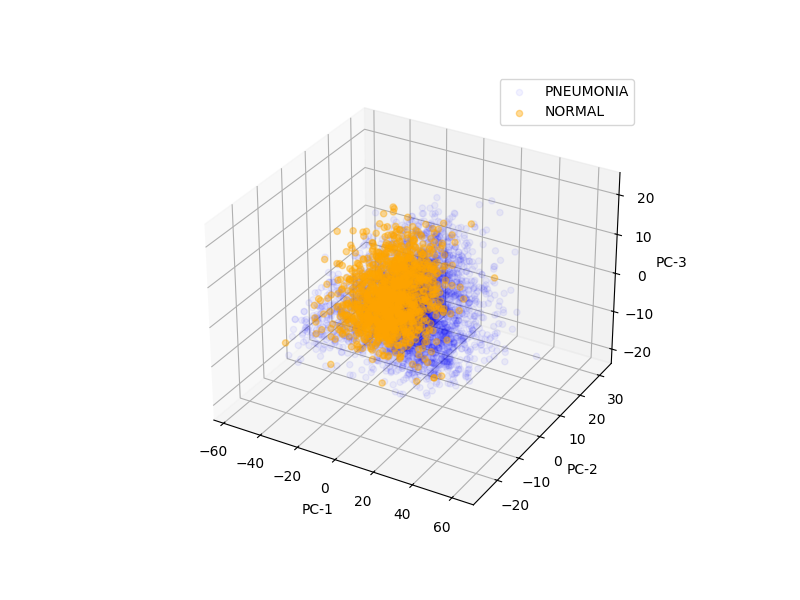

In [64]:
%matplotlib widget

# Assuming X_3d is your 3D data array and labels is your corresponding labels array
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(
    x_train_pca[y_train == 1, 0],
    x_train_pca[y_train == 1, 1],
    x_train_pca[y_train == 1, 2],
    color="blue",
    label="PNEUMONIA",
    alpha=0.05
)

ax.scatter(
    x_train_pca[y_train == 0, 0],
    x_train_pca[y_train == 0, 1],
    x_train_pca[y_train == 0, 2],
    color="orange",
    label="NORMAL",
    alpha=0.4
)

ax.set_xlabel('PC-1')
ax.set_ylabel('PC-2')
ax.set_zlabel('PC-3')

plt.legend()
plt.show()

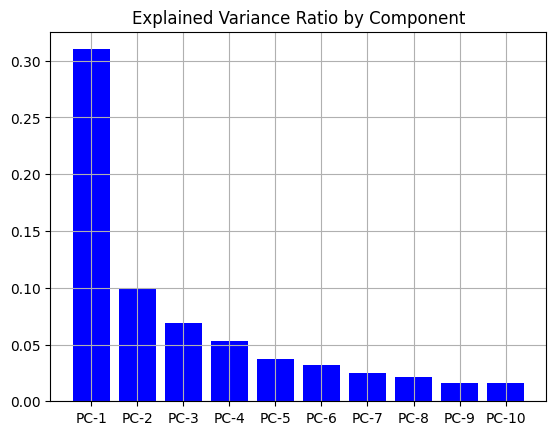

In [66]:
%matplotlib inline 

explained_variance_ratio_10 = pca.explained_variance_ratio_[:10]
pc_10 = [f"PC-{i}" for i in range(1, len(explained_variance_ratio_10) + 1)]

plt.bar(pc_10, explained_variance_ratio_10, color="blue")
plt.title("Explained Variance Ratio by Component")
plt.grid(True)
plt.show()

In [67]:
x_test_pca = pca.transform(normalize_images(x_test))
x_eval_pca = pca.transform(normalize_images(x_eval))

np.save("./datasets/x_test_pca", x_test_pca)
np.save("./datasets/x_eval_pca", x_eval_pca)

## Model Discovery

We will use `RandomizedSearchCV` with the `roc-auc` scoring to be able to test a wide array of hyperparameters the most efficient way possible. The reason why we use `roc-auc` scoring is that we have class imbalance and accuracy only captures the correct guesses. So if we have a **dummy** model that only guesses the majority class, we will have a score of $\approx63\%$ pretty _decent_ right ? So instead, `roc-auc` calculates the **area under the Receiver Operating Characteristic** curve which basically plots the **true positive rate** (TPR) against the **false positive rate** (FPR) for different threshold values. In other terms it evaluates the ability for a model to differentiate between positive and negative instances across threshold values. We will see an example of how it works for `SVC` and for the rest we'll just use the score.


In addition, for each model, after extracting the best parameters we will `train` and `evaluate` them with the found parameters using **Cross Validation** (with `StratifiedKFold` to preserve percentage of samples of each class) whilst keeping track of `["f1", "accuracy", "roc_auc"]` scores for maximum generalization.


In [18]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


def randomized_search_cv(estimator, param_distributions: dict):
    rand_search_cv = RandomizedSearchCV(
        estimator, param_distributions, scoring="recall", cv=cv, random_state=42
    )
    rand_search_cv_results = rand_search_cv.fit(x_train_pca, y_train)
    return rand_search_cv_results

In [19]:
from sklearn.svm import SVC

svc = SVC()

param_distributions = {
    "C": [0.1, 1, 10, 100, 1000],
    "kernel": ["rbf", "poly", "sigmoid"],
    "degree": list(range(1, 11)),  # Just for "poly"
}

svc_search = randomized_search_cv(svc, param_distributions)
svc_search.best_params_

{'kernel': 'rbf', 'degree': 7, 'C': 10}

In [20]:
import re
import pandas as pd


def plot_cv_results(cv_results_, title=""):
    df = pd.DataFrame(cv_results_)
    df = df.sort_values(by="rank_test_score")

    pattern = re.compile(r"split[0-9]+_test_score")

    split_columns = [c for c in df.columns.values.tolist() if pattern.match(c)]

    # Picking only the columns to plot
    df = df[["params"] + split_columns]
    df["params"] = df["params"].astype(str)

    # Rotating the dataframe
    df = df.melt(id_vars="params", value_vars=split_columns)

    plt.figure(figsize=(10, 6))
    sns.boxplot(df, x="value", y="params", fliersize=0)
    plt.xlabel("ROC_AUC Score")
    plt.title(title)
    plt.show()

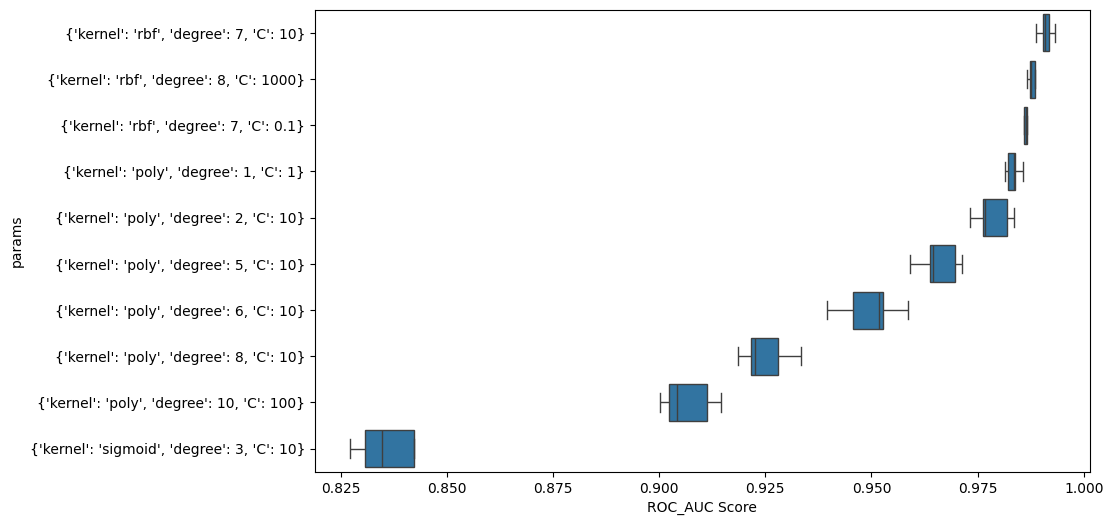

In [21]:
%matplotlib inline

plot_cv_results(svc_search.cv_results_)

In [43]:
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    roc_auc_score,
    recall_score,
)

from src.utils.helpers import plot_confusion_matrix

models_scores = {}


# Evaluating a model from best params
def evaluate_model(model, cv):
    # set the params to be the best combination
    model_name = type(model).__name__
    model.set_params(**cv.best_params_)

    # train the model with the best params combination
    model.fit(x_train_pca, y_train)

    y_pred = model.predict(x_test_pca)

    cm = confusion_matrix(y_test, y_pred)

    models_scores[model_name] = {
        "accuracy": accuracy_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
    }

    plot_confusion_matrix(cm, model_name)

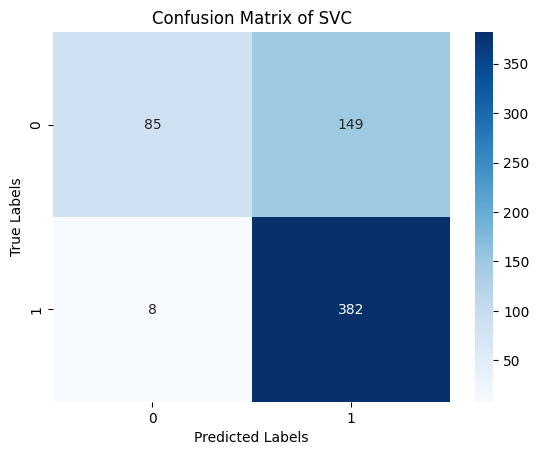

In [44]:
evaluate_model(svc, svc_search)

In [40]:
from sklearn.ensemble import RandomForestClassifier

param_distributions = {
    "n_estimators": [50, 100, 200],
    "max_depth": [10, 100, 1000, None],
    "max_features": ["sqrt", "log2", 0.5],
    "min_samples_leaf": [1, 2, 5, 10],
}

rfc = RandomForestClassifier()

rfc_search = randomized_search_cv(rfc, param_distributions)
rfc_best_params = rfc_search.best_params_

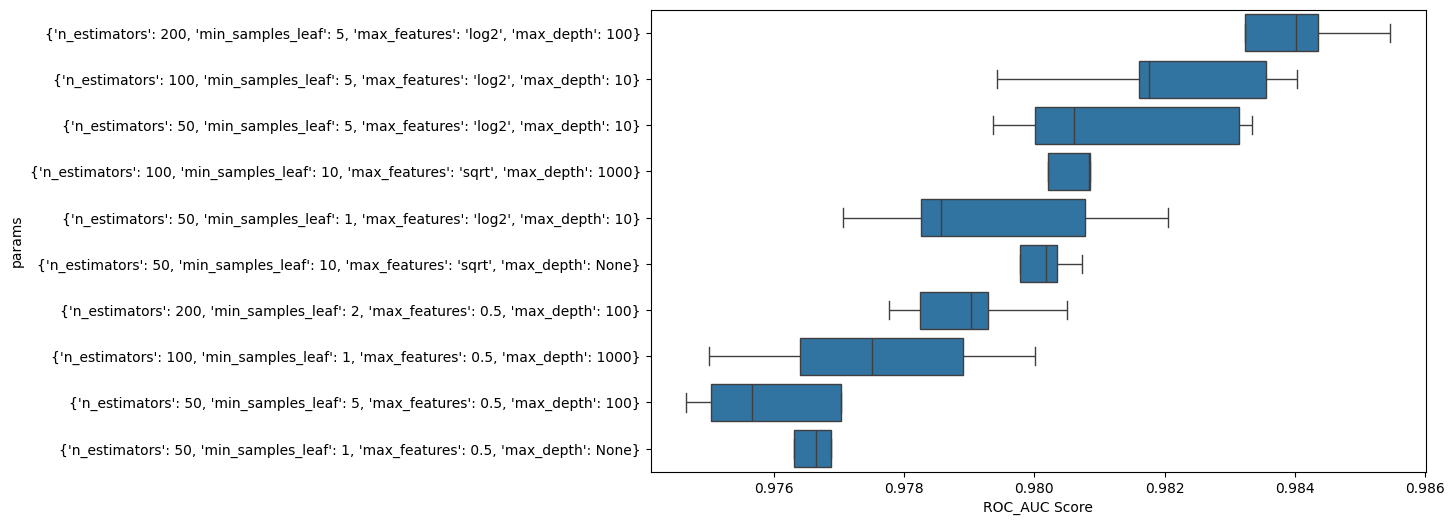

In [41]:
%matplotlib inline

plot_cv_results(rfc_search.cv_results_)

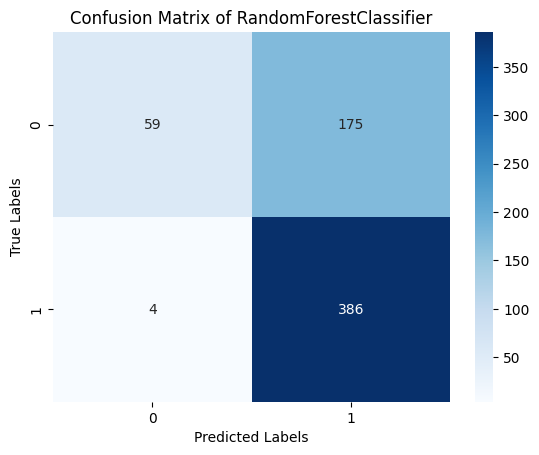

In [42]:
evaluate_model(rfc, rfc_search)

### NeuralNetPy

In this section, we will test different Neural network architectures in the light of finding the best one for our use case.

For each, we will be using `Adam` optimizer alongside a `BCE` (log loss).


The following function `train_evaluate_model`, takes in a `NeuralNetPy.model`. It will :

- Fetch the _train_ and _eval_ data
- Split the _train_ data into `90-10` resulting in an extra _test_ data set on which the model will be tested during training.
- The model will then make predictions over the _eval_ set.
- Finally the function will plot the following :
  - Chart representing the **evolution** of the `train_loss` and `test_loss` over the epochs
  - Chart displaying the **evolution** of `train_accuracy` and `test_accuracy` over the epochs
  - Confusion matrix of the **predictions** made
  - Bar plot of the resulting scores (`accuracy`, `roc_auc`, `recall`) over the _eval_ data


In [3]:
from src.utils.helpers import train_evaluate_model
from src.utils.NeuralNetPy import (
    models,
    layers,
    optimizers,
    WEIGHT_INIT,
    ACTIVATION,
    LOSS,
)

We will start with a simple architecture like the one that worked well for MNIST here : https://www.tensorflow.org/datasets/keras_example#build_an_evaluation_pipeline

The architecture is :

- Input layer (31 n)
- Dense layer (128 n, `relu` activation)
- Output layer (2 n, `softmax` activation)


In addition, for the same architecture we will try training with **stratified batches** and **normal batches** to see the difference (over 50 epochs).


In [10]:
network_normal_batch = models.Network()

network_normal_batch.addLayer(layers.Dense(31))
network_normal_batch.addLayer(layers.Dense(128, ACTIVATION.RELU, WEIGHT_INIT.GLOROT))
network_normal_batch.addLayer(layers.Dense(2, ACTIVATION.SOFTMAX, WEIGHT_INIT.GLOROT))

network_normal_batch.setup(optimizer=optimizers.Adam(0.01), loss=LOSS.BCE)

Training modelDropping last mini-batch (size : 86 < 128)
Total mini-batches created : 36



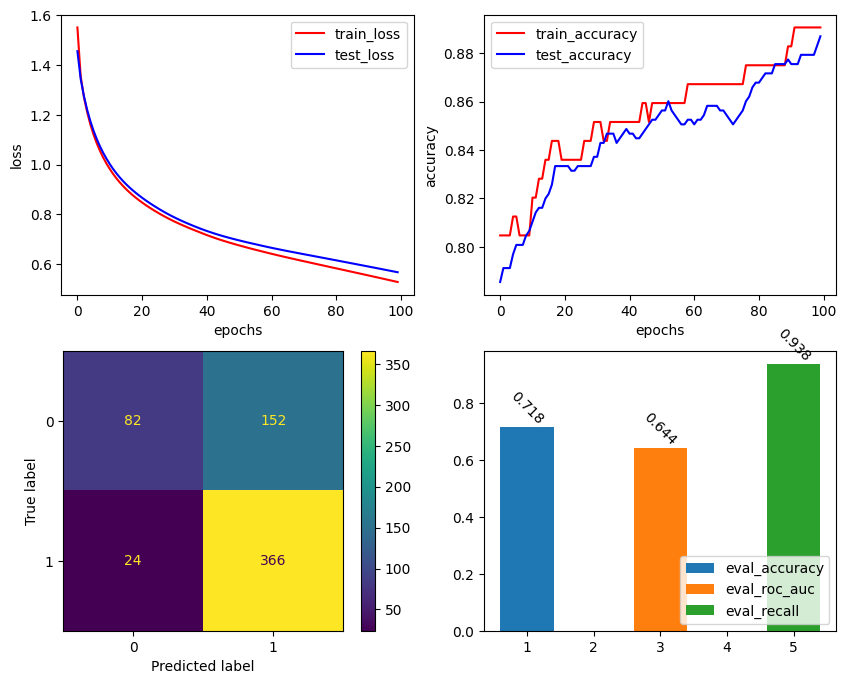

In [11]:
train_evaluate_model(
    network_normal_batch,
    network_normal_batch.getSlug(),
    epochs=100,
    shuffle=True,
    verbose=True,
    dropLast=True,
)

In [12]:
network_stratified_batch = models.Network()

network_stratified_batch.addLayer(layers.Dense(31))
network_stratified_batch.addLayer(
    layers.Dense(128, ACTIVATION.RELU, WEIGHT_INIT.GLOROT)
)
network_stratified_batch.addLayer(
    layers.Dense(2, ACTIVATION.SOFTMAX, WEIGHT_INIT.GLOROT)
)

network_stratified_batch.setup(optimizer=optimizers.Adam(0.01), loss=LOSS.BCE)

Class count for (0) = 1207 - classBatchSize = 32
Training model
Class count for (1) = 3487 - classBatchSize = 95
Dropping last mini-batch (size : 86 < 128)
Total mini-batches created : 36


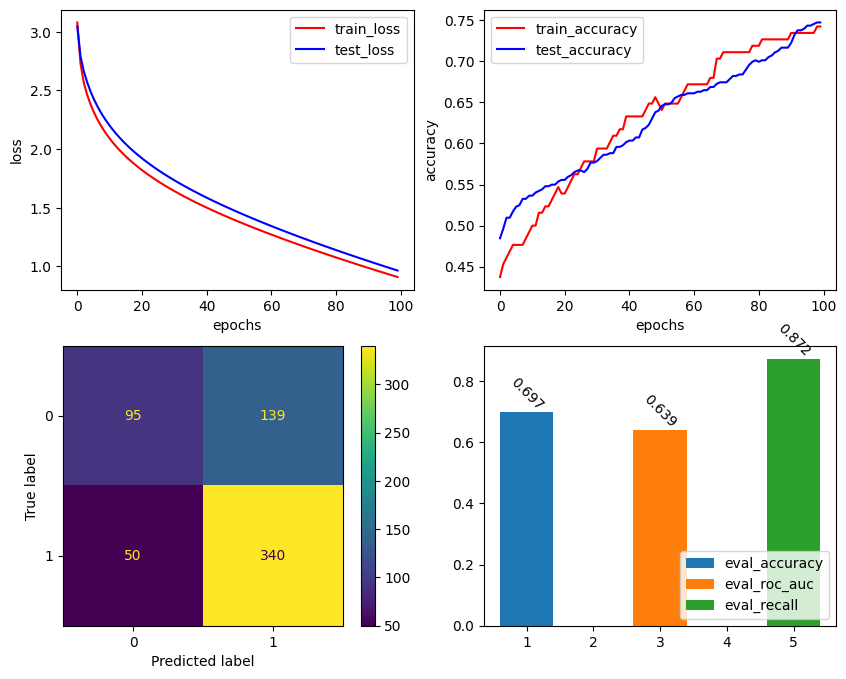

In [13]:
train_evaluate_model(
    network_stratified_batch,
    network_stratified_batch.getSlug(),
    epochs=100,
    stratified=True,
    shuffle=True,
    verbose=True,
    dropLast=True,
)

In the case of **normal batching** strategy, we had more volatile results (depending on the shuffle). In contrast, **stratified batching** led to more stable results (due to its nature). Therefore **stratified batching** will be used for the next steps.


Before moving on to trying out different network architecture, let's see how different **input scalers** can affect the base architecture that we began with.

Scalers to test :

- `MaxAbsScaler` & `Normalizer` - Values are mapped depending on the presence of negative OR positive values
- `MinMaxScaler` & `Normalizer`- Rescale the data in range [0, 1] (Sensitive to presence of outliers)
- `QuantileTransformer` - applies a non linear transformation resulting in a uniform distribution with range [0, 1] (making outliers indistinguishable from inliers)


In [20]:
import matplotlib.pyplot as plt


def plot_pca_3d(pca, y):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")

    # Assuming X_3d is your 3D data array and labels is your corresponding labels array
    ax.scatter(
        pca[y == 1, 0],
        pca[y == 1, 1],
        pca[y == 1, 2],
        color="blue",
        label="PNEUMONIA",
        alpha=0.05,
    )

    ax.scatter(
        pca[y == 0, 0],
        pca[y == 0, 1],
        pca[y == 0, 2],
        color="orange",
        label="NORMAL",
        alpha=0.4,
    )

    ax.set_xlabel("PC-1")
    ax.set_ylabel("PC-2")
    ax.set_zlabel("PC-3")

    plt.legend()
    plt.show()

In [17]:
import numpy as np

preprocessed_data = np.load("./datasets/processed_data.npz", allow_pickle=True)
y_train = preprocessed_data["y_train"]
x_train_pca = np.load("./datasets/x_train_pca.npy")

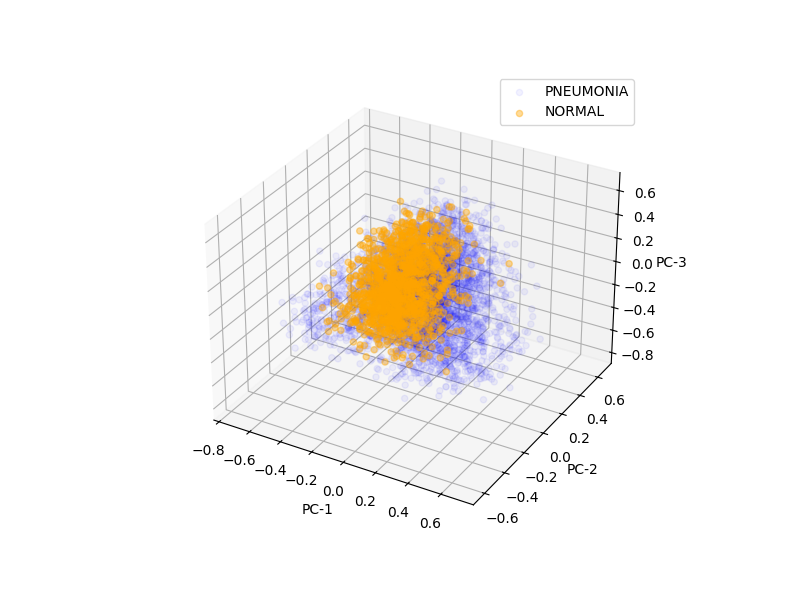

In [28]:
%matplotlib widget

from sklearn.preprocessing import MaxAbsScaler, Normalizer
from sklearn.pipeline import Pipeline

maxAbs_pipe = Pipeline([('MaxAbs', MaxAbsScaler()), ('normalizer', Normalizer())])
maxAbs_pca = maxAbs_pipe.fit_transform(x_train_pca)

plot_pca_3d(maxAbs_pca, y_train)

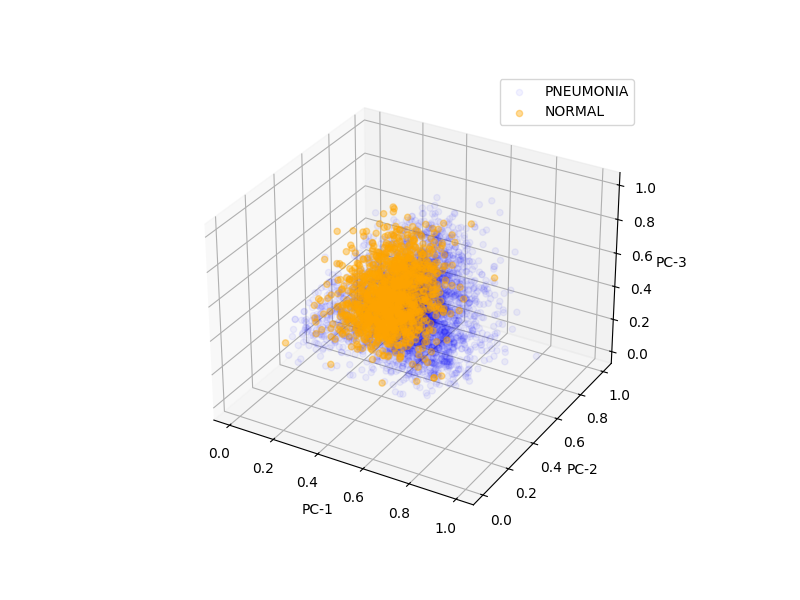

In [25]:
%matplotlib widget

from sklearn.preprocessing import MinMaxScaler

minMax_pca = MinMaxScaler().fit_transform(x_train_pca)

plot_pca_3d(minMax_pca, y_train)

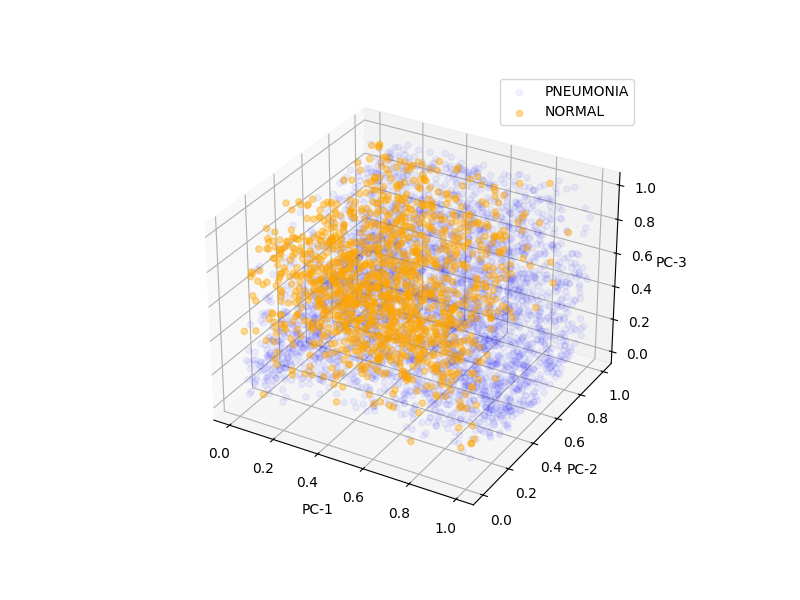

In [26]:
%matplotlib widget

from sklearn.preprocessing import QuantileTransformer

quant_pca = QuantileTransformer().fit_transform(x_train_pca)

plot_pca_3d(quant_pca, y_train)